# Intro

<img width=600 src="images/buick_skylark.jpeg">
<p>This notebook demonstrates solving a regression problem on the example of the <a href="https://archive.ics.uci.edu/ml/datasets/auto+mpg">Auto MPG Data Set</a>. MPG (miles per gallon) is a measure of cars' fuel efficiency. The dataset provides MPG values for different cars alongside with their other specs like acceleration and weight, so we can train a model to predict MPG based on these specs.</p>

# Import dependencies

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time

import sys
sys.path.insert(0, "..")
import mymllib

%matplotlib inline
sns.set(font_scale=1.2)

# Exploratory data analysis

## Download the dataset

In [24]:
columns = ["MPG", "Cylinders", "Displacement", "Horsepower",
           "Weight", "Acceleration", "Model Year", "Origin", "Name"]
dataset = pd.read_table(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data",
    names=columns, sep="\s+", na_values = "?")
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,Name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


## Remove examples with missing data

As we can see, there are 6 cars in the dataset with missing data about their horsepower:

In [25]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
Name            0
dtype: int64

Since the number of the cars with missing data is small and the goal of this notebook is to showcase usage of the library rather than to build a perfect MPG prediction model, we can just drop these rows without trying to handle missing values:

In [26]:
dataset = dataset.dropna()

## Select features and target

We select MPG as the target value and all other columns (except the name) as features:

In [27]:
target_column = columns[0]
feature_columns = columns[1:-1]

print("Target:", target_column)
print("Features:", feature_columns)

Target: MPG
Features: ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']


## Train/Test split

Here we use a simple 80%/20% train/test split:

In [28]:
train_dataset = dataset.sample(frac=0.8, random_state=123)
test_dataset = dataset.drop(train_dataset.index)

## Target's distribution

Let's plot the distribution of MPG values:

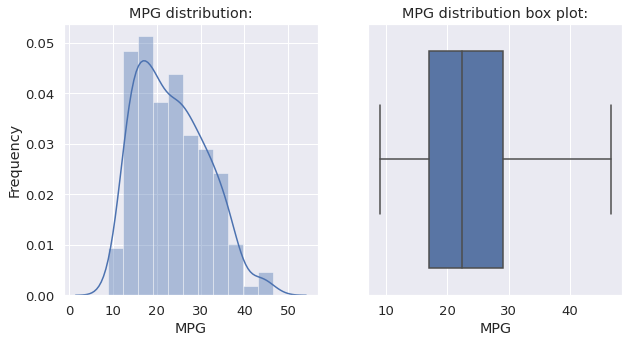

In [29]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.title("MPG distribution:")
sns.distplot(train_dataset[target_column])
plt.xlabel("MPG")
plt.ylabel("Frequency")

plt.subplot(122)
plt.title("MPG distribution box plot:")
sns.boxplot(train_dataset[target_column])
_ = plt.xlabel("MPG")

As plots above show, the distribution of the target value has some positive skewness. To verify this, let's calculate the exact skewness value:

In [30]:
scipy.stats.skew(train_dataset[target_column])

0.4773928172073085

Let's also calculate some other statistics of the target value distribution:

In [31]:
train_dataset[target_column].describe()

count    314.000000
mean      23.468790
std        7.888159
min        9.000000
25%       17.000000
50%       22.450000
75%       29.000000
max       46.600000
Name: MPG, dtype: float64

As we can see, the target value (MPG) ranges from 9 to 46.6 with the mean equal to 23.47 and the standard deviation equal to 7.89. There are no outliers, however the distribution of the target value is positively skewed.

## Correlations

Let's see how the target value depends on each of the features:

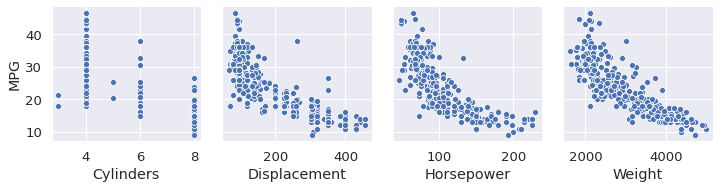

In [10]:
_ = sns.pairplot(train_dataset, y_vars=target_column, x_vars=feature_columns[:4])

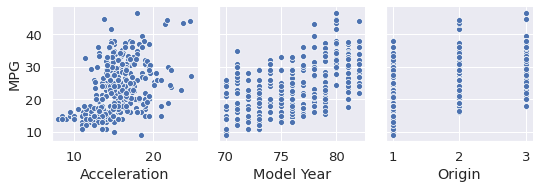

In [11]:
_ = sns.pairplot(train_dataset, y_vars=target_column, x_vars=feature_columns[4:])

The correlations look as expected, for instance, higher weight of a car means higher fuel consumption. What should be noted is that the correlations are not exactly linear, so to capture them we'll need to use models like linear regression with polynomial features or a neural network with at least one hidden layer.

# Models

## Features/target split

We split both train and test datasets into X (features) and y (target) to make them suitable for training and testing models:

In [12]:
X_train = train_dataset[feature_columns]
y_train = train_dataset[target_column]

X_test = test_dataset[feature_columns]
y_test = test_dataset[target_column]

## Linear regression

As were shown above, dependencies between the features and the target are non-linear and thus for linear regression to capture them we need to create polynomial features:

In [13]:
X_train_poly = mymllib.preprocessing.add_polynomial(X_train, 2)
X_test_poly = mymllib.preprocessing.add_polynomial(X_test, 2)

Since features are scaled differently (like acceleration and weight), we normalize the data so that all features would have a mean of 0 and a variance of 1:

In [14]:
data_scaler = mymllib.preprocessing.DataScaler().fit(X_train_poly)
X_train_norm = data_scaler.scale(X_train_poly)
X_test_norm = data_scaler.scale(X_test_poly)

Now we can train the model:

In [15]:
linear_regression = mymllib.regression.LinearRegression(
    regularization_param=0.1)
linear_regression.fit(X_train_norm, y_train)

Lets test the model's performance both on train and test sets. Mean absolute error (MAE) and mean absolute percentage error (MAPE) are used as metrics:

In [16]:
import mymllib.metrics.regression as metrics

def test_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print("Train MAE:", metrics.mean_absolute_error(
        y_train, y_train_pred))
    print("Test MAE:", metrics.mean_absolute_error(
        y_test, y_test_pred))
    
    print()
    
    print("Train MAPE:", metrics.mean_absolute_percentage_error(
        y_train, y_train_pred))
    print("Test MAPE:", metrics.mean_absolute_percentage_error(
        y_test, y_test_pred))

test_model(linear_regression, X_train_norm, y_train, X_test_norm, y_test)

Train MAE: 1.8913042710430001
Test MAE: 1.9068488709462839

Train MAPE: 8.00600532463123
Test MAPE: 8.636686266172317


## Neural network

We will use a neural network with a hidden layer to capture non-linear dependencies, so we can skip creating polynomial features and just perform normalization:

In [17]:
data_scaler = mymllib.preprocessing.DataScaler().fit(X_train)
X_train_norm = data_scaler.scale(X_train)
X_test_norm = data_scaler.scale(X_test)

Here we train and test a feed-forward fully-connected neural network with a single hidden layer:

In [22]:
neural_net = mymllib.neural_networks.RegressionNeuralNetwork(
    hidden_layers=(4,),
    regularization_param=0.1)
neural_net.fit(X_train_norm, y_train)
test_model(neural_net, X_train_norm, y_train, X_test_norm, y_test)

Train MAE: 1.8680294568401292
Test MAE: 1.8792724529767089

Train MAPE: 8.042101342246625
Test MAPE: 8.631952310696049
